# California Wildfire Analysis -- 1992 - 2020

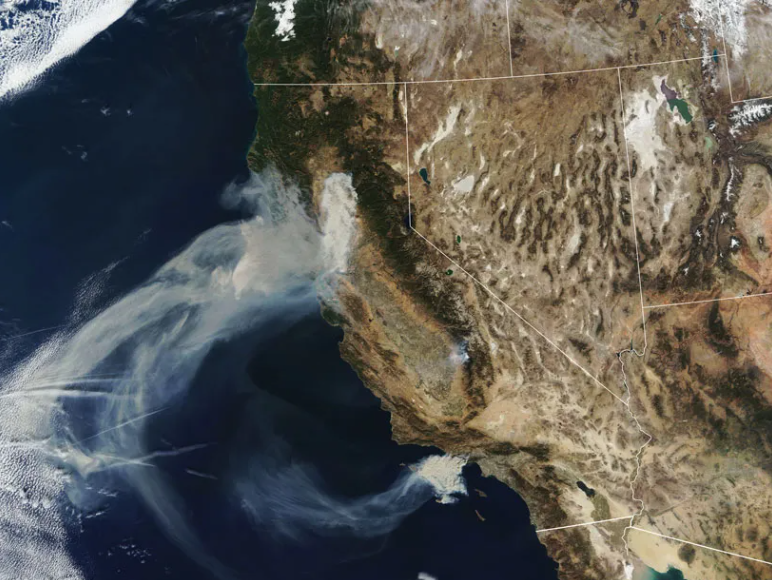

<font size="1">Photo credit:  NASA Earth Observatory image by Joshua Stevens, using MODIS data from NASA EOSDIS/LANCE and GIBS/Worldview</font>

This analysis explores wildfire patterns in the state of California, utilizing historical fire data sourced from the US Forest Service and subregional-scale watershed boundaries provided by the US Geological Survey. Through the integration of these critical datasets, the aim is to create two interactive plots that will illuminate the landscape of wildfires in the nation. The first plot will visually map the occurrence and maximum sizes of fires across different regions, providing insights into the spatial distribution of these events. The second plot, presented as a chloropleth map, will unveil the density. 


In [1]:
# import libraries

import os
import warnings

import earthpy as et
import geodatasets as gds
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
import pyogrio

pd.set_option('display.max_columns', None)
# warnings.filterwarnings("ignore")


In [2]:
# Download the Watershed Boundary Dataset (WBD)
wbd_url = ("https://prd-tnm.s3.amazonaws.com/StagedProducts"
           "/Hydrography/WBD/National/GDB/WBD_National_GDB.zip")
wbd_dir = et.data.get_data(url=wbd_url)
# print(wbd_dir)  # Print the directory

# Download California boundary shapefile
ca_boundary = gpd.read_file("https://data.ca.gov/dataset/"
                            "e212e397-1277-4df3-8c22-40721b095f33/"
                            "resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b/"
                            "download/ca-state-boundary.zip")

ca_boundary = ca_boundary.to_crs('EPSG:6414')

wbd_path = os.path.join(wbd_dir, 'WBD_National_GDB.gdb')
# wbd_hu2_gdf = gpd.read_file(wbd_path, layer='WBDHU2', from_disk=True)
wbd_hu4_gdf = gpd.read_file(wbd_path, layer='WBDHU4', from_disk=True)
# wbd_hu6_gdf = gpd.read_file(wbd_path, layer='WBDHU6', from_disk=True)

# wbd_hu2_gdf = wbd_hu2_gdf.to_crs('EPSG:6414')
# wbd_hu2_aoi = gpd.clip(wbd_hu2_gdf, ca_boundary)
wbd_hu4_gdf = wbd_hu4_gdf.to_crs('EPSG:6414')
wbd_hu4_aoi = gpd.clip(wbd_hu4_gdf, ca_boundary)

# wbd_hu4_aoi.plot()
# wbd_hu4_aoi.head()

# print(ca_boundary.crs)
# print(wbd_hu4_gdf.crs)


In [3]:
# Count the number of unique CA watershed ()'name') values
num_unique_huc4 = len(wbd_hu4_aoi['name'].unique())

# Print the number of unique 'RTTYP' values
# print("Number of unique watershed values:", num_unique_huc4)


In [4]:
# Download the fire data
fire_url = ("https://www.fs.usda.gov/rds/archive/"
            "products/RDS-2013-0009.6/"
            "RDS-2013-0009.6_Data_Format2_GDB.zip")
fire_dir = et.data.get_data(url=fire_url)


In [10]:
# Ingest the fire data and create a GeoDataFrame
fire_path = os.path.join(fire_dir, 'Data', 'FPA_FOD_20221014.gdb')
if not 'fire_raw_gdf' in globals():
    print('fire_raw does not exist. Loading...')
    fire_raw_gdf = pyogrio.read_dataframe(fire_path, layer='Fires')

fire_raw_gdf = fire_raw_gdf.to_crs('EPSG:6414')
# print(fire_raw_gdf.crs)

fire_ca_gdf = gpd.clip(fire_raw_gdf, ca_boundary)

fire_gdf = (fire_ca_gdf[['FOD_ID', 'DISCOVERY_DATE',
                         'NWCG_GENERAL_CAUSE', 'FIRE_SIZE',
                         'geometry']].set_index('FOD_ID'))

fire_gdf.DISCOVERY_DATE = pd.to_datetime(fire_gdf.DISCOVERY_DATE)

#  NOTE--Fire size here is in acres

# print(type(fire_gdf))


In [6]:
# Spatialy join the watershed GeoDataFrame to the fire GeoDataFrame
fire_region_gdf = (wbd_hu4_aoi[['name', 'geometry']].
                   sjoin(fire_gdf, how='inner', predicate='intersects'))
fire_region_pdf = (fire_region_gdf
                   .groupby(['name', fire_region_gdf.DISCOVERY_DATE.dt.year])
                   .agg(
                       max_fire_size=('FIRE_SIZE', 'max'),
                       sum_fire_size=('FIRE_SIZE', 'sum'),
                       num_fires=('index_right', 'count')))

fire_region_pdf['firesum_area_sqkm'] = fire_region_pdf['sum_fire_size'] * 0.00404686
fire_region_pdf['max_fire_size_sqkm'] = fire_region_pdf['max_fire_size'] * 0.00404686


# print(type(fire_region_gdf)) 
# print(type(fire_region_pdf))

# fire_region_pdf


In [7]:
# compute area of regional watersheds
wbd_hu4_aoi[['name', 'areasqkm', 'geometry']]


# Compute total fires in each watershed
fire_count_df = (fire_region_pdf.reset_index()[['name', 'num_fires', 'firesum_area_sqkm']]
                .groupby('name').sum())


# Compute fire density (num fires/watershed area) and burn ratio (total fire area burned/watershed area)
fire_density_gdf = (wbd_hu4_aoi.set_index('name')
                    .join(fire_count_df)
                    [['num_fires', 'areasqkm', 'firesum_area_sqkm', 'geometry']])

fire_density_gdf['fire_density_per_sqkm'] = (
    fire_density_gdf.num_fires / fire_density_gdf.areasqkm)

fire_density_gdf['burn_ratio_per_sqkm'] = (
    fire_density_gdf.firesum_area_sqkm / fire_density_gdf.areasqkm)

# Normalize the Fire Density data
min_density = fire_density_gdf['fire_density_per_sqkm'].min()
range_fire_density = (fire_density_gdf['fire_density_per_sqkm'].max() -
                      fire_density_gdf['fire_density_per_sqkm'].min())

fire_density_gdf['fire_den_norm'] = (
    (fire_density_gdf.fire_density_per_sqkm - min_density) / range_fire_density)

# Normalize the Burn Ratio data
min_burn = fire_density_gdf['burn_ratio_per_sqkm'].min()
range_burn_ratio = (fire_density_gdf['burn_ratio_per_sqkm'].max() -
                      fire_density_gdf['burn_ratio_per_sqkm'].min())

fire_density_gdf['burn_ratio_norm'] = (
    (fire_density_gdf.burn_ratio_per_sqkm - min_burn) / range_burn_ratio)




# print(type(fire_density_gdf))
# fire_density_gdf
# fire_count_df
# wbd_hu4_aoi



The plots below exhibit the Fire Density (number of fires / watershed area) and Burn Ration (total area burned / watershed area) to view the difference between the number and size of fires on the subregional watershed areas. The data has been normalized so as to compare the two plots using the same scale.

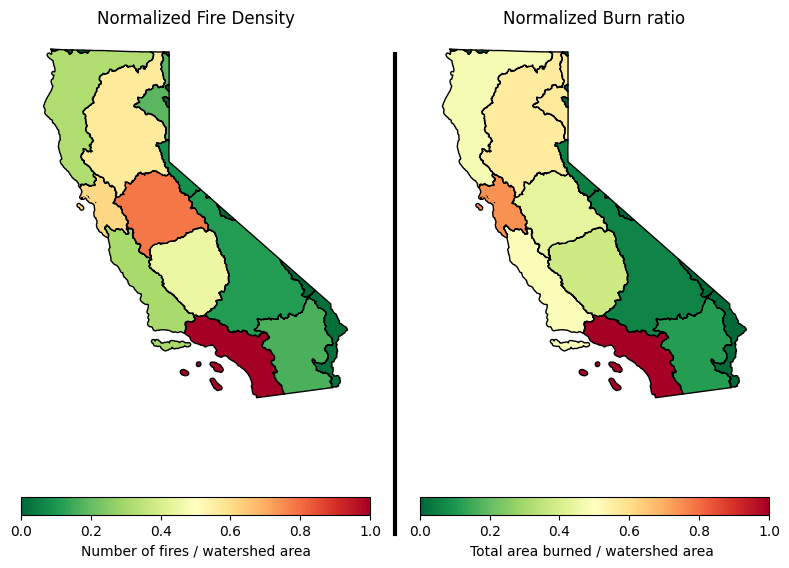

In [8]:
# Figure with two plots

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))


# Create the normalized fire density choropleth map
fire_density_gdf.plot(ax=ax1, column='fire_den_norm', edgecolor='black', cmap='RdYlGn_r',
                      legend=True, legend_kwds={'label': 'Number of fires / watershed area', 'orientation': 'horizontal'})                    
ax1.set_title('Normalized Fire Density')
ax1.set_axis_off()

# Create the normalized burn-ratio choropleth map
fire_density_gdf.plot(ax=ax2, column='burn_ratio_norm',
                      edgecolor='black', legend=True,
                      legend_kwds={'label': 'Total area burned / watershed area ', 'orientation': 'horizontal'},
                      cmap='RdYlGn_r')
ax2.set_title('Normalized Burn ratio')
ax2.set_axis_off()

# Draw a vertical line at those coordinates
line = plt.Line2D((.5,.5),(.1,.9), color="k", linewidth=3)
fig.add_artist(line)

fig.tight_layout(w_pad=2.0)
plt.show()

This dynamic plot exhibits three varibles:

        1. Largest fire on record within watershed
        2. Total area burned in watershed
        3. Total number of fires that occured in watershed

In [9]:
# Set values for ylabels and titles
labels = pd.DataFrame(dict(
    column_name = ['max_fire_size_sqkm', 'firesum_area_sqkm', 'num_fires'],
    ylabel = ['Max Fire Size (sqkm)', 'Total area burned (sqkm)', 'Number of Fires'],
    title = ['Largest fire on record in region', 
             'Total area burned by fire in region',
             'Total number of fires in the region']))

def fire_plot(region_name, df=fire_region_pdf, labels=labels):
    """
    Create a multi-panel plot for a region

    Parameters
    ----------
    region_name : str
      The name of the region to generate a plot for. Must exists 
      in the 'name' index of df.
    df : pd.DataFrame
      The dataframe with the data to plot. Columns much match
      an item in labels.column_name to be plotted
    labels : pd.DataFrame
      Plot labels. Must have a 'column_name', 'ylabel', and 'title'
      columns with str values. Each row will be a subplot.

    Returns
    -------
    plot : hv.core.layout.Layout
      A holoviews plot layout or similar. For use with hv.DynamicMap.
    """

    # Generate a subplot for each row in the labels
    subplots = []
    # Iterate through the labels row by row
    for i, labs in labels.iterrows():
        # Create subplot
        subplot = (
            df.xs(region_name, level='name')
            [[labs.column_name]]
            .hvplot(xlabel='Year', ylabel=labs.ylabel, title=labs.title,
                    width=800))
        subplots.append(subplot)

    # Stack the subplots vertically
    plot = hv.Layout(subplots).cols(1)
    return plot

# Create a dropdown menu to switch between regions
(
    hv.DynamicMap(
        # The plotting function for the two-panel fire history
        fire_plot,
        # Define the dimension for the dropdown
        kdims=[('region', 'Region')])
    # Add the explicit indexing - region names as a bokeh dimension
    .redim.values(region=fire_region_pdf.reset_index().name)
    .opts(shared_axes=True))

    

BokehModel(combine_events=True, render_bundle={'docs_json': {'3ba31849-c2c2-4b50-89a7-817d8ce78886': {'version…



## The Data


The Watershed Boundary Dataset (WBD) is an essential geographic database maintained by the United States Geological Survey (USGS). It comprises an extensive collection of official gaged watersheds throughout the United States.  The WBD provides a comprehensive and standardized framework for delineating and defining these watershed boundaries, making it a crucial resource for hydrological and environmental studies. This dataset plays a vital role in the management and analysis of water resources, facilitating a better understanding of the nation's hydrography and helping to inform various water-related decision-making processes.


The fire dataset is a comprehensive spatial database of wildfires that occurred in the United States from 1992 to 2020. It was originally created to support the national Fire Program Analysis (FPA) system and includes records of wildfires reported by federal, state, and local fire organizations. This dataset, known as the Fire Program Analysis fire-occurrence database (FPA FOD), comprises approximately 2.3 million geo-referenced wildfire records, covering a total area of 180 million acres burned during the 29-year period.

<font size='2'>United States Geological Survey. "Watershed Boundary Dataset (WBD). 2023, https://www.usgs.gov/national-hydrography/watershed-boundary-dataset.</font>

<font size='2'>USDA Forest Service. "Wildfires in the United States (1992-2020) - Fire Program Analysis fire-occurrence database (FPA FOD)." Retrieved from https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.6.</font>

In [11]:
%%capture
%%bash
jupyter nbconvert vector_fire_analysis.ipynb --to html --no-input
